# initial mount


In [ ]:
# ✅ 安裝必要套件
# !pip install tensorflow opencv-python matplotlib

# ✅ 掛載 Google Drive
from google.colab import drive
import os
model_path = r'/content/drive/MyDrive/app/Project/skuda web/sudoku_mnist_model.h5'
drive.mount('/content/drive')

# 🔹 載入必要模組
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from datetime import datetime

# ✅ 主程式函式封裝


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# VV2

In [ ]:
#@title module
def load_mnist_model():
    if os.path.exists(model_path):
        print("✅ 使用 Google Drive 中的已訓練模型")
        return load_model(model_path)

    print("🚧 模型不存在，開始訓練中...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=128, epochs=2, verbose=1, validation_data=(x_test, y_test))
    model.save(model_path)
    print("✅ 模型已儲存至 Google Drive")
    return model

def extract_and_predict(img, model):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, 1, 1, 11, 2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    rect_found = False
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            pts = approx.reshape(4, 2)
            rect_found = True
            break

    if rect_found:
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        dst = np.array([
            [0, 0],
            [450 - 1, 0],
            [450 - 1, 450 - 1],
            [0, 450 - 1]
        ], dtype="float32")

        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(gray, M, (450, 450))
        warped_color = cv2.warpPerspective(img, M, (450, 450))
    else:
        print("⚠️ 無法偵測九宮格，使用原圖")
        warped = cv2.resize(gray, (450, 450))
        warped_color = cv2.resize(img, (450, 450))

    board = []
    raw_image_cells = []
    cell_size = 50

    for y in range(9):
        row_digits = []
        row_raw = []
        for x in range(9):
            x1, y1 = x * cell_size, y * cell_size
            cell = warped[y1:y1 + cell_size, x1:x1 + cell_size]
            raw_cell = warped_color[y1:y1 + cell_size, x1:x1 + cell_size]  # 原始顏色圖像格子

            resized = cv2.resize(cell, (28, 28))
            _, binarized = cv2.threshold(resized, 128, 255, cv2.THRESH_BINARY_INV)

            contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                x2, y2, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                digit = binarized[y2:y2+h, x2:x2+w]
                digit = cv2.resize(digit, (18, 18))
                centered = np.zeros((28, 28), dtype=np.uint8)
                centered[5:23, 5:23] = digit
            else:
                centered = binarized

            if np.count_nonzero(centered) < 20:
                row_digits.append(0)
            else:
                input_img = centered.reshape(1, 28, 28, 1).astype('float32') / 255
                prediction = model.predict(input_img, verbose=0)
                digit = int(np.argmax(prediction))
                row_digits.append(digit)

            row_raw.append(raw_cell)

        board.append(row_digits)
        raw_image_cells.append(row_raw)

    return board, raw_image_cells

def generate_timestamped_filename(base_name: str, extension: str = "txt") -> str:
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    return f"{base_name}_{timestamp}.{extension}"

def show_result(board, image_cells, save_f = True, img_s=None):
    if img_s is not None:
        print("\n== ✅ 原始九宮格圖片輸出 ==")
        img_rgb = cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title("顯示圖像")
        plt.axis('off')
        plt.show()

    print("\n== ✅ Python 陣列格式輸出 ==")
    formatted = "[\n" + ",\n".join(str(row) for row in board) + "\n]"
    print(formatted)

    if save_f:
        file_name = generate_timestamped_filename("sudoku_result.txt")
        with open(file_name, "w", encoding="utf-8") as f:
            f.write(formatted)
        files.download(file_name)
        print(f'\033[1;33mget text from file {file_name} in folder "download"\033[0m\n')

    fig, axs = plt.subplots(9, 10, figsize=(15, 12))
    fig.suptitle("🧠 每格原始圖像 + 預測結果（含行號）", fontsize=18)

    for y in range(9):
        for x in range(10):
            ax = axs[y, x]
            ax.axis('off')

            if x == 0:
                ax.text(0.5, 0.5, f"Row {y+1}", fontsize=14, ha='center', va='center')
            else:
                img = image_cells[y][x - 1]
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
                # ax.set_title(str(board[y][x - 1]), fontsize=24)
                if board[y][x - 1] > 0:
                    ax.set_title(str(board[y][x - 1]), fontsize=24, color='red', backgroundcolor='#ffff88', weight='bold')
                else:
                    ax.set_title(str(board[y][x - 1]), fontsize=24)


    plt.tight_layout()
    plt.show()


📤 請上傳數獨圖片（jpg 或 png 格式）


Saving Screenshot_20250804_232407_Sudoku.jpg to Screenshot_20250804_232407_Sudoku.jpg
✅ 使用 Google Drive 中的已訓練模型
⚠️ 無法偵測九宮格，使用原圖

== ✅ Python 陣列格式輸出 ==
[
[7, 0, 9, 8, 0, 0, 5, 4, 0],
[0, 0, 0, 7, 0, 0, 0, 0, 0],
[5, 8, 8, 8, 4, 8, 8, 2, 8],
[0, 0, 4, 5, 0, 0, 0, 5, 9],
[0, 0, 8, 0, 0, 0, 7, 0, 0],
[5, 7, 0, 0, 0, 4, 8, 0, 0],
[0, 4, 0, 0, 8, 0, 0, 0, 5],
[0, 0, 0, 0, 0, 5, 0, 0, 0],
[0, 5, 7, 0, 0, 5, 9, 0, 2]
]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

get text from file sudoku_result.txt_2025-08-04_15-25-10.txt in folder "download"



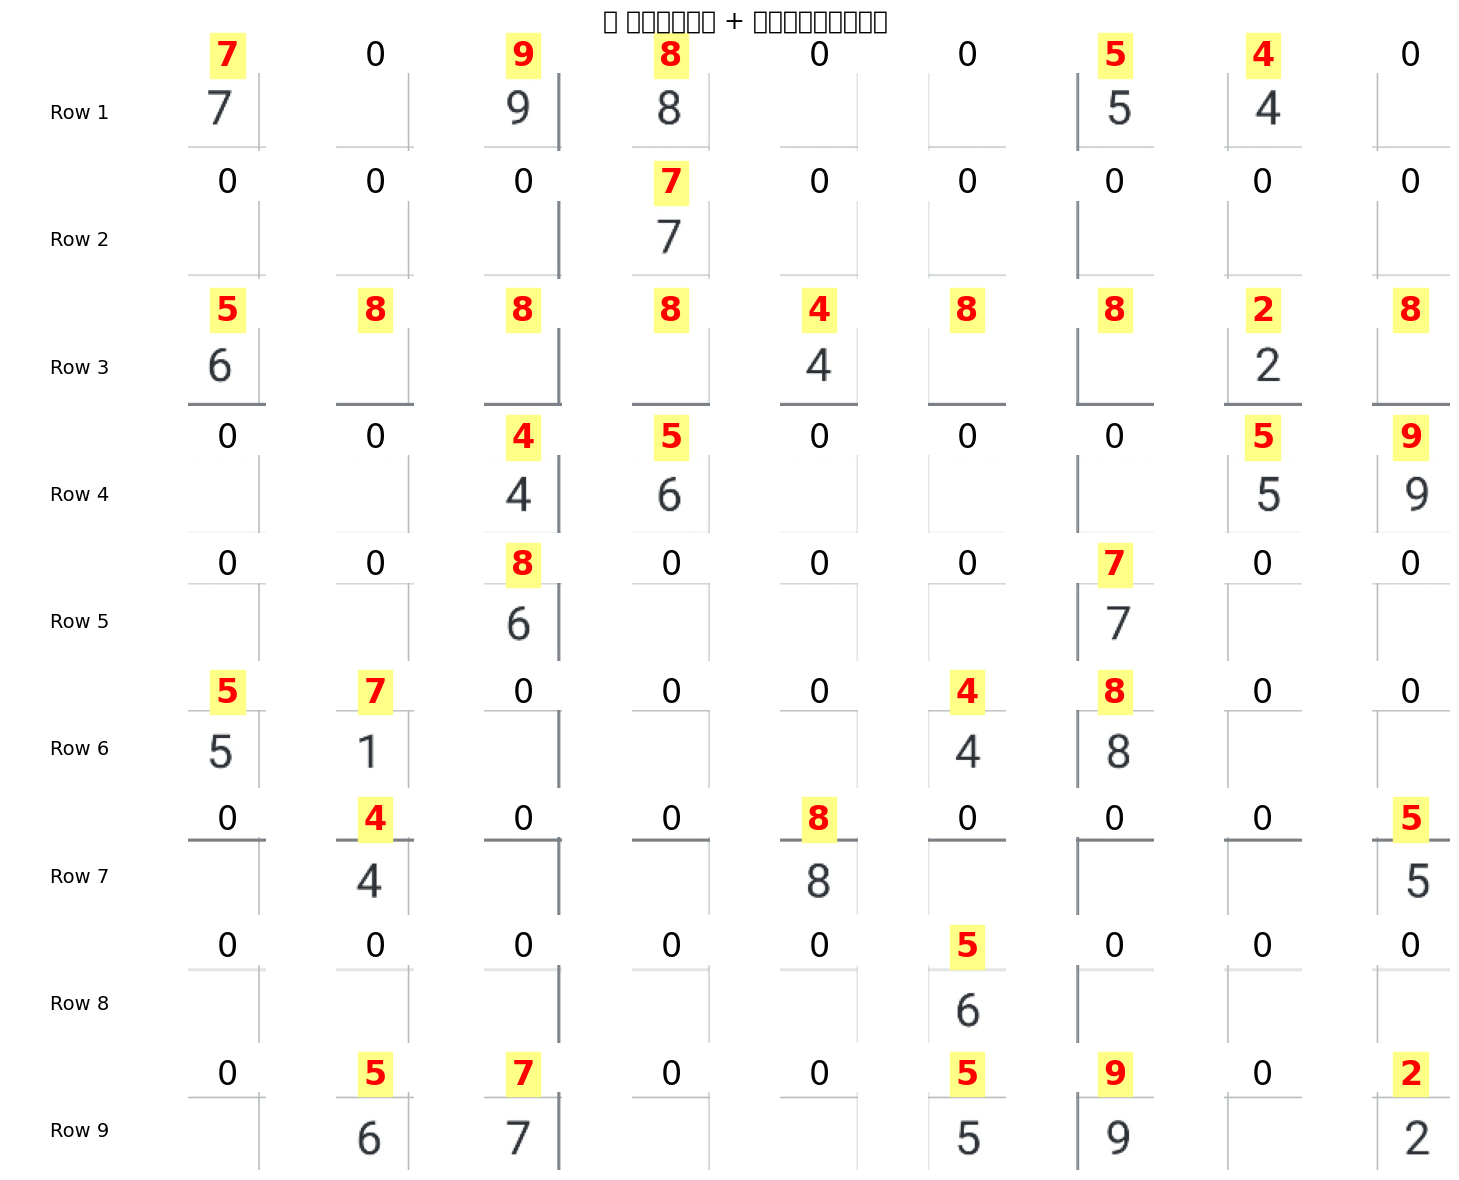

In [7]:
#@title Run
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# ✅ 主流程執行
print("📤 請上傳數獨圖片（jpg 或 png 格式）")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)

model = load_mnist_model()
board, image_cells = extract_and_predict(img, model)
show_result(board, image_cells, save_f=True, img_s=None)

In [8]:
a=\
[
  [7, 0, 9, 8, 0, 0, 5, 4, 0],
  [0, 0, 0, 7, 0, 0, 0, 0, 0],
  [6, 0, 0, 0, 4, 0, 0, 2, 0],
  [0, 0, 4, 6, 0, 0, 0, 5, 9],
  [0, 0, 6, 0, 0, 0, 7, 0, 0],
  [5, 1, 0, 0, 0, 4, 8, 0, 0],
  [0, 4, 0, 0, 8, 0, 0, 0, 5],
  [0, 0, 0, 0, 0, 6, 0, 0, 0],
  [0, 6, 7, 0, 0, 5, 9, 0, 2]
  ]
a

[[7, 0, 9, 8, 0, 0, 5, 4, 0],
 [0, 0, 0, 7, 0, 0, 0, 0, 0],
 [6, 0, 0, 0, 4, 0, 0, 2, 0],
 [0, 0, 4, 6, 0, 0, 0, 5, 9],
 [0, 0, 6, 0, 0, 0, 7, 0, 0],
 [5, 1, 0, 0, 0, 4, 8, 0, 0],
 [0, 4, 0, 0, 8, 0, 0, 0, 5],
 [0, 0, 0, 0, 0, 6, 0, 0, 0],
 [0, 6, 7, 0, 0, 5, 9, 0, 2]]

# VV1

In [ ]:
# ✅ 安裝必要套件
# !pip install tensorflow opencv-python matplotlib

# ✅ 掛載 Google Drive
from google.colab import drive
import os
model_path = r'/content/drive/MyDrive/app/Project/skuda web/sudoku_mnist_model.h5'
drive.mount('/content/drive')

# 🔹 載入必要模組
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:


# ✅ 上傳圖片（jpg/png 格式）
print("📤 請上傳數獨圖片（jpg 或 png 格式）")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)

# ✅ 模型建構與訓練（使用 MNIST 預訓練模型）
def load_mnist_model():
    if os.path.exists(model_path):
        return load_model(model_path)

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=128, epochs=2, verbose=0, validation_data=(x_test, y_test))
    model.save(model_path)
    return model

model = load_mnist_model()

# ✅ 圖像預處理 + 偵測九宮格
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, 1, 1, 11, 2)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

rect_found = False
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        pts = approx.reshape(4, 2)
        rect_found = True
        break

if rect_found:
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    dst = np.array([
        [0, 0],
        [450 - 1, 0],
        [450 - 1, 450 - 1],
        [0, 450 - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(gray, M, (450, 450))
else:
    warped = cv2.resize(gray, (450, 450))

# ✅ 切割成 9x9 格子，辨識每格數字
board = []
cell_size = 50

for y in range(9):
    row = []
    for x in range(9):
        x1, y1 = x * cell_size, y * cell_size
        cell = warped[y1:y1 + cell_size, x1:x1 + cell_size]

        # 二值化與裁切居中處理
        resized = cv2.resize(cell, (28, 28))
        _, binarized = cv2.threshold(resized, 128, 255, cv2.THRESH_BINARY_INV)

        contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            x2, y2, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
            digit = binarized[y2:y2+h, x2:x2+w]
            digit = cv2.resize(digit, (18, 18))
            centered = np.zeros((28, 28), dtype=np.uint8)
            centered[5:23, 5:23] = digit
        else:
            centered = binarized

        if np.count_nonzero(centered) < 20:
            row.append(0)
            continue

        input_img = centered.reshape(1, 28, 28, 1).astype('float32') / 255
        prediction = model.predict(input_img, verbose=0)
        digit = int(np.argmax(prediction))
        row.append(digit)
    board.append(row)

# ✅ 顯示結果
# import pandas as pd
# print("== ✅ 辨識結果陣列 ==")
# df = pd.DataFrame(board)
# display(df)

print("\n== ✅ Python 陣列格式輸出 ==")
print("[\n" + ",\n".join(str(row) for row in board) + "\n]")


In [ ]:
assert False, 'stop here'